# Implementation of Liquid Neural Networks

The focus of this document is the implementation of the LTC networks, in form of LTC, CFC and NCP. This document does not mention what they are, but rather how to use them in different scenarios.




The implementation discussed in this document is through `ncps` package. This package provides 2 models, LTC (Liquid Time-Constant) and CFC (Closed-Form Continuous-Time) models. Both these models are available as `tf.keras.layers.Layer` or `torch.nn.Module` RNN layers.

The Tensorflow bindings are available via the `ncps.tf` module. \
The Pytorch bindings are available via the `ncps.torch` module.

In [ ]:
# installing the ncps package
! pip install ncps seaborn

## Tensorflow usage

I will only focus on the tensorflow implementation of the Neural Nets.

In [3]:
# how to define an LTC or CfC cell
from ncps.tf import LTC, CfC

units = 28
rnn1 = LTC(units)                 # fully-connected LTC
rnn2 = CfC(units)                 # fully-connected CfC

In [4]:
# we can also define custom wirings
# this is essential for plotting the rnn cell
from ncps import wirings

ncp_wiring = wirings.AutoNCP(28, 4)       # 28 total neurons (excluding sensory input neurons), 4 output neurons
fc_wiring = wirings.FullyConnected(8,1)   # 8 total neurons, 1 motor output neuron (7 inter neurons)
# fc_wiring = wirings.FullyConnected(8)     # 8 total neurons, all of which are motor neurons

rnn3 = LTC(ncp_wiring)            # NCP wired LTC
rnn4 = CfC(ncp_wiring)            # NCP wired CfC
rnn5 = LTC(fc_wiring)             # Fully connected LTC, with custom wiring
rnn6 = LTC(ncp_wiring, return_sequences = True)            # NCP wired LTC

You can only plot the above rnn cells:
- if you  use the wirings class to define wiring.
- and if you have built a model.

In [5]:
# how to add the above rnn cell in a neural network?
from tensorflow import keras


model = keras.models.Sequential([

    # this layer decides the input sensory neurons
    keras.layers.InputLayer(input_shape=(None, 2)),

    # here we could add layers before and after the LTC rnn cell

    # rnn1,
    LTC(ncp_wiring, return_sequences=True),
])

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss='mean_squared_error'
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ltc_4 (LTC)                 (None, None, 4)           3456      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can create an RNN cell before defining the model, or while defining the model.
- `return_Sequences = True` argument in the LTC class, adds one more dimension to the output.

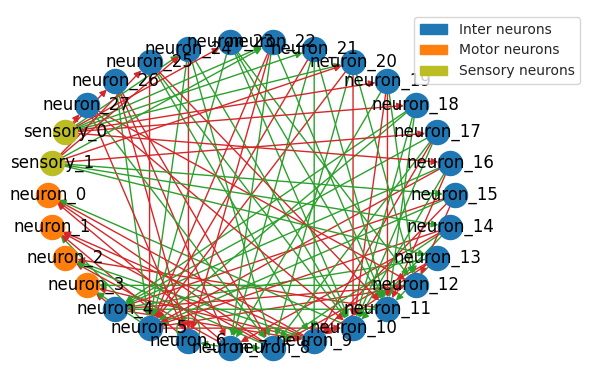

In [6]:
# plotting the wirings of the rnn cell of the model
import seaborn as sns
import matplotlib.pyplot as plt


# you can only plot the wiring
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ncp_wiring.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### How to combine NCP cell with arbitraty `tf.keras.layers`?

Here is an example to build an image sequence classifier. This combines an NCP cell with Conv2D layers etc.

In [7]:
from ncps.wirings import AutoNCP
from ncps.tf import LTC
from tensorflow import keras

# image resolution
height, width, channels = (78, 200, 3)

ncp_wiring = AutoNCP(32, output_size=8)
ncp = LTC(ncp_wiring, return_sequences=True)

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, height, width, channels)),
        keras.layers.TimeDistributed(
            keras.layers.Conv2D(32, (5, 5), activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv2D(64, (5, 5), activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D()),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.TimeDistributed(keras.layers.Dense(32, activation="relu")),
        ncp,
        keras.layers.TimeDistributed(keras.layers.Activation("softmax")),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss='sparse_categorical_crossentropy',
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 74, 196, 3   2432      
 ributed)                    2)                                  
                                                                 
 time_distributed_1 (TimeDi  (None, None, 37, 98, 32   0         
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, None, 33, 94, 64   51264     
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, None, 16, 47, 64   0         
 stributed)                  )                                   
                                                                 
 time_distributed_4 (TimeDi  (None, None, 48128)      

## Example 1: UGV Direction Control

The purpose of this example is to learn how to stack an NCP with a convolutional head. This is similar to the architecture for end-to-end driving in the paper. But it is a highly simplified example.

The problem is of the collision avoidance and autonomous steering of the ground robot.

These are the simplifications:
1. Here we use a 2D Lidar signals. The camera images are not used.

2. We won't separate the feature-maps of the last convolutional layer as it was done in the paper.

3. Thus we, use Conv1D layers rather than Conv2D.

In [1]:
# Install dependencies if they are not installed yet
!pip install -U seaborn ncps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

`icra2020_lidar_collision_avoidance` \
The dataset we will use considers the task of maneuvering a mobile robot to aboid obstacles in its path.

It can be found on `ncps.datasets`.

**Describing the dataset** \
Each example in the dataset consists of a feature vector x and a output label y. There are total 928 examples, split into 675 test examples (\~73%) and 250 validation examples (\~27%).

Each feature vector has point cloud information of 541 points, in terms polar coordinates. So, the distance of 541 points is stored, spanning an angle of -2.35 to 2.35 radians. (\~-135 to +135 degrees from the forward direction. 270 degree 2D Lidar.) The robot estimates pose (angle and lateral displacement
from initial pose) as a time series sampled at 10Hz. So, every 100 ms, robot records these 541 points. The displacement measurement range of the Lidar used can be [0.5m, 20m]. It can also extend to 50m depending on the model. As the robot was restricted to indoor settings, the values approach 6m in the dataset.

The dataset has no test set, because this is a robotic control task where each action influences future observations. As the environment feedback cannot be adequately modelled suring supervised training, so instead of test-set, we directtly should test on the live robot, or simulation.

The training of the model is done through back-propagation through time, by splitting each training and validation sequence into multiple sub-sequences of
length 32, i.e. corresponding to 3.2 real-time seconds.

The output label is the steering direction in the range [-1,1]. 0 for going straight, -1 for turning left and +1 for turning right.

This dataset was collected by manually steering the robot around the obstacles on 29 different tracks.

In [3]:
# download and load the dataset
from ncps.datasets import icra2020_lidar_collision_avoidance
(x_train, y_train), (x_valid, y_valid) = icra2020_lidar_collision_avoidance.load_data()

# print shapes
print("x_train:", str(x_train.shape))
print("y_train:", str(y_train.shape))
print("x_valid:", str(x_valid.shape))
print("y_valid:", str(y_valid.shape))

x_train: (678, 32, 541, 1)
y_train: (678, 32, 1)
x_valid: (250, 32, 541, 1)
y_valid: (250, 32, 1)


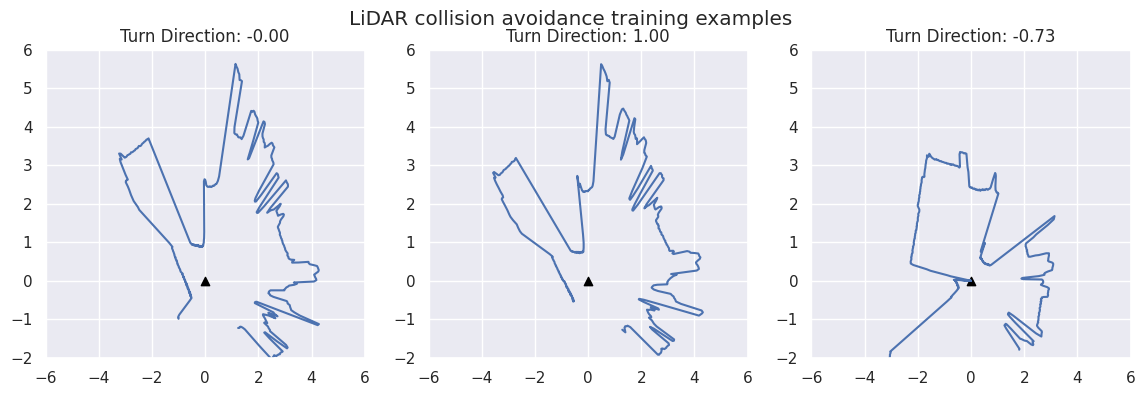

In [4]:
# helper function to plot a sample
def plot_lidar_point_cloud(lidar_points, ax):
  """
  This is a helper function for plotting polar-based lidar point cloud.
  :param lidar_points: array of lidar displacement readings, from lidar
  :param ax: figure
  """
  angles = np.linspace(-2.35, 2.35, len(lidar_points))
  x = lidar_points * np.cos(angles)
  y = lidar_points * np.sin(angles)
  ax.plot(y,x)
  ax.scatter([0], [0], marker="^", color="black")
  ax.set_xlim((-6,6))
  ax.set_ylim((-2,6))


# plot a few samples
sns.set()
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
plot_lidar_point_cloud(x_train[0,0,:,0],ax1)   # first example, first time step reading, all points
plot_lidar_point_cloud(x_train[0,12,:,0],ax2)  # first example, 13th time step reading, all points
plot_lidar_point_cloud(x_train[9,0,:,0],ax3)  # 10th example, first time step reading, all points

ax1.set_title("Turn Direction: {:0.2f}".format(y_train[0,0,0]))
ax2.set_title("Turn Direction: {:0.2f}".format(y_train[0,12,0]))
ax3.set_title("Turn Direction: {:0.2f}".format(y_train[9,0,0]))

fig.suptitle("LiDAR collision avoidance training examples")
fig.show()

### How to build a model to solve this?

Note to solve a control task, we need information of previous states of the system.

Hence, we create a Neural Network consisting of a feed-forward followed by a recurrent sub-model.

The input data are provided as a time-series which at each time-step is the observed full-laser rangefinder scan. The network then feeds this LiDAR scan through feed-forward part to obtain a 32-dimensional laten representation of current input. The recurrent NCP then takes this latent features as input and updates its internal state and outputs prediction.

In [5]:
total_lidar_points = x_train.shape[2]        # 541
channels = x_train.shape[3]                  # 1

wiring = AutoNCP(21,1)    # 21 total, 1 motor

# TimeDistributed layer independently applies the
# Conv1D/MaxPool1D/Dence over each time-step of the input time-series.

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, total_lidar_points, channels)),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(18, 5, strides=3, activation="relu")
        ),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(20, 5, strides=2, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(22, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(24, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.TimeDistributed(keras.layers.Dense(32, activation="relu")),
        LTC(wiring, return_sequences=True),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss="mean_squared_error",
)

model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 time_distributed (TimeDistributed)          (None, None, 179, 18)                   108            
                                                                                                    
 time_distributed_1 (TimeDistributed)        (None, None, 88, 20)                    1820           
                                                                                                    
 time_distributed_2 (TimeDistributed)        (None, None, 44, 20)                    0              
                                                                                                    
 time_distributed_3 (TimeDistributed)        (None, None, 40, 22)                    2222           
                                                                       

#### Shapes of the layer outputs

It is important to talk about shapes because during training if there is a shape mismatch between the predicted value and ground truth, it will raise an error.

First let us look at how the output label looks like?
`y_train.shape` returns (678,32,1). \
What does this mean? \
678 means that there are 678 total examples. And for each of these examples the output is (32,1) vector. Because we train the network through backpropagation through time, we split the sequence of training data into sub-sequence of 32 time steps. This becomes our batch size during training.

Note: we need to make the output label shape, according to this batch size as well. Just specifying the batch size during `model.fit()` will raise shape errors.

Now the model shapes:
1. The input shape is (541,1), not considering the batch size here.
2. After first convolution, kernel size of 5, reduces the size by 2 pixels on each side, i.e. 4 pixels. And a stride of 3, reduces the size of 537 to 179. Also we are learning 18 filters, so it becomes (179,18).
3. Again, we loose 4 pixels due to kernel size of 5, 175 pixels are covered with a stride of 2, so 87+1. And we are learning 20 filters. So output size is (88,20).
4. Maxpooling reduces size by 2. So output is (44,20).
5. Conv1D layer with a kernel size of 5, reduced pixels by amount of 4 in total. As 22 filters need to be learned, output is (40,22).
6. Another maxpool layer reduces size by 2. So output is (20,22).
7. Another Conv1D layer kernel size of 5 reduces pixels by 4. So output is (16,24).
8. Flatten layer puts them in a line, so 16*24 becomes 384.
9. A dense layer of 32 has an output of 32 only.
10. The NCP will take 32 inputs and produce an output of 1. So the final output will be 1.


What is going on with these None in the shapes? \
This means that the size of this dimension is not fixed and is variable. It will be determined based on the input data during runtime.
So, we have 2 dimensions whose shape is variable. What do these variable dimensions represent?

We specify an input size of (None, 541, 1). This none represents the variable sequence length, which will depend on the time steps we want to feed to the model. Here, we are specifying the any sequence length explicitly.

Another None comes from the batch size. So, in the output shape of (None, None, 1) of the LTC layer, first None comes from batch size, second one comes from variable sequence length.


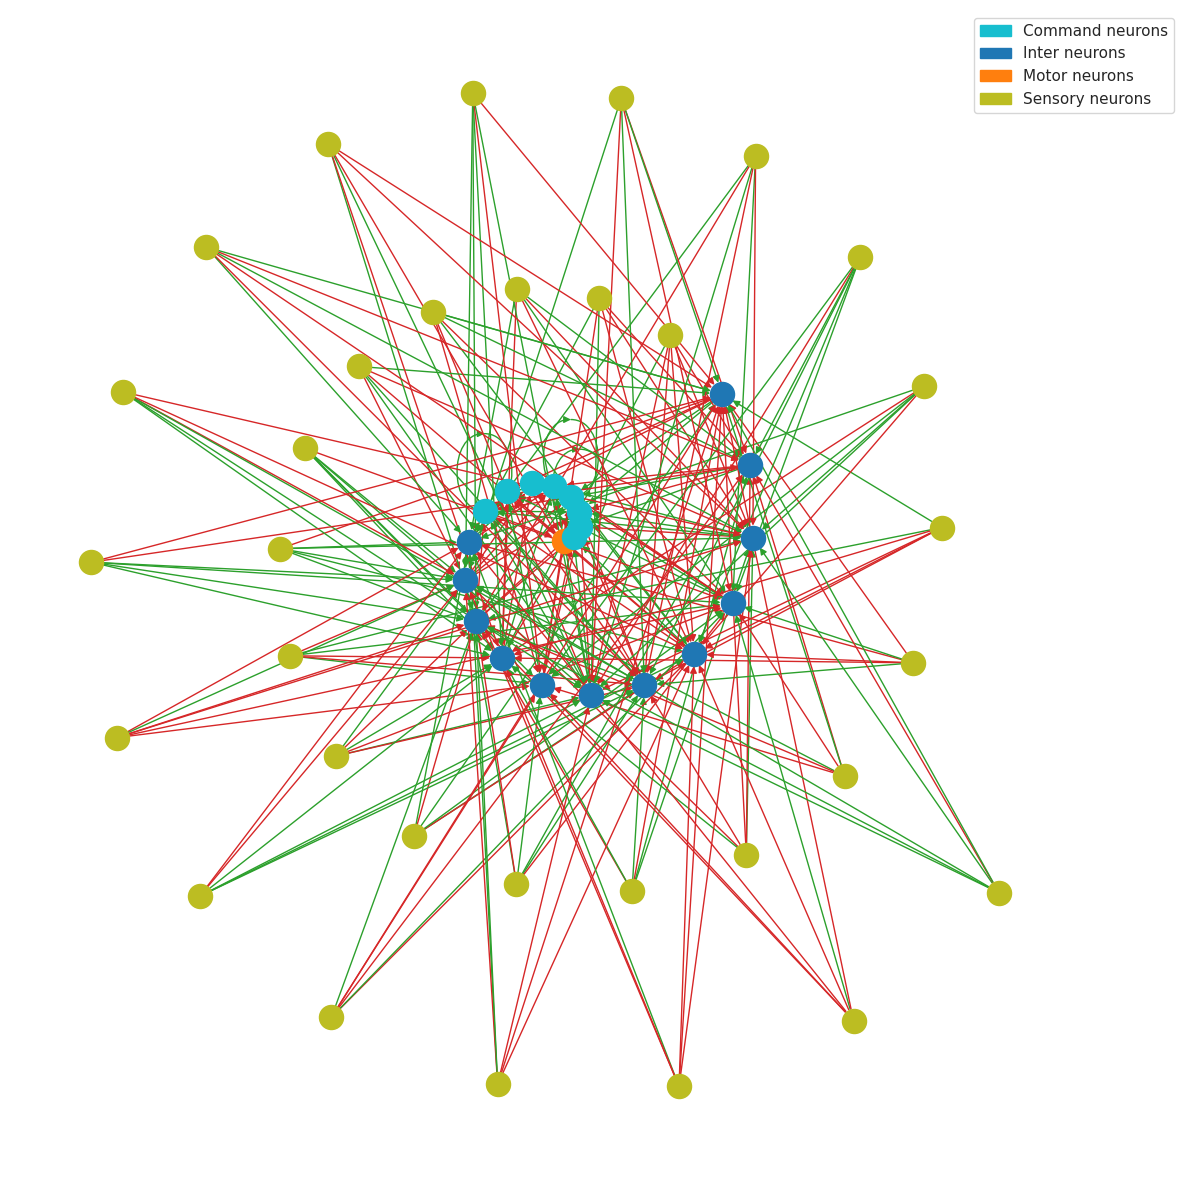

In [6]:
# drawing the rnn sub-model
sns.set_style("white")
plt.figure(figsize=(12,12))
legend_handles = wiring.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Training this model

We do the following tasks:
1. Evaluate untrained model on validation set.
2. Train the model
3. Evaluate trained model on vaidation set.

In [7]:
model.evaluate(x_valid, y_valid)

8/8 [==============================] - 4s 55ms/step - loss: 0.1861


0.18612785637378693

In [8]:
# train the model
model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20,
    validation_data=(x_valid,y_valid)
)

Epoch 1/20
22/22 [==============================] - 18s 315ms/step - loss: 0.2060 - val_loss: 0.1592
Epoch 2/20
22/22 [==============================] - 7s 339ms/step - loss: 0.1704 - val_loss: 0.1367
Epoch 3/20
22/22 [==============================] - 6s 274ms/step - loss: 0.1509 - val_loss: 0.1369
Epoch 4/20
22/22 [==============================] - 8s 388ms/step - loss: 0.1409 - val_loss: 0.1147
Epoch 5/20
22/22 [==============================] - 6s 270ms/step - loss: 0.1318 - val_loss: 0.1184
Epoch 6/20
22/22 [==============================] - 8s 346ms/step - loss: 0.1308 - val_loss: 0.1198
Epoch 7/20
22/22 [==============================] - 6s 273ms/step - loss: 0.1309 - val_loss: 0.1183
Epoch 8/20
22/22 [==============================] - 7s 332ms/step - loss: 0.1304 - val_loss: 0.1187
Epoch 9/20
22/22 [==============================] - 6s 268ms/step - loss: 0.1226 - val_loss: 0.1136
Epoch 10/20
22/22 [==============================] - 7s 334ms/step - loss: 0.1257 - val_loss: 0.115

In [9]:
model.evaluate(x_valid, y_valid)

8/8 [==============================] - 0s 26ms/step - loss: 0.1313


0.1312890201807022

In [29]:
output = model.predict(x_train[0:1,0:10,:,:])
output.shape

1/1 [==============================] - 0s 25ms/step


In [40]:
output[0,:,0]
y_train[0,0:10,0]

array([-0., -0., -0., -0., -0., -0.,  1.,  1.,  1.,  1.], dtype=float32)

In [33]:
degrees = (np.interp(output[0,:,0],[-1,1] ,[-135,135]))

In [34]:
degrees

array([ -1.39210219,  -9.02357809, -12.46489517, -12.81382307,
       -11.18368808, -11.07134812,   3.65483332,  28.83484259,
        20.50882056,  39.38074797])

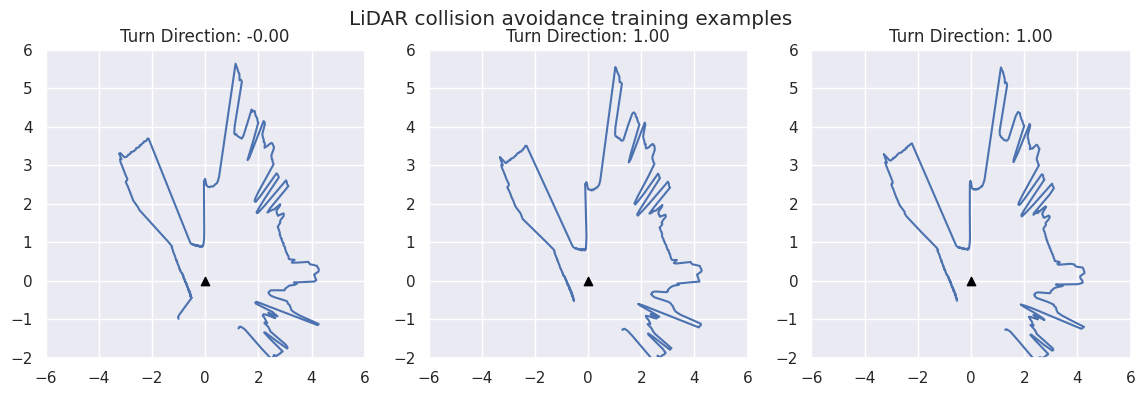

In [37]:
# plot a few samples
sns.set()
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
plot_lidar_point_cloud(x_train[0,1,:,0],ax1)   # first example, first time step reading, all points
plot_lidar_point_cloud(x_train[0,9,:,0],ax2)  # first example, 13th time step reading, all points
plot_lidar_point_cloud(x_train[0,8,:,0],ax3)  # 10th example, first time step reading, all points

ax1.set_title("Turn Direction: {:0.2f}".format(y_train[0,1,0]))
ax2.set_title("Turn Direction: {:0.2f}".format(y_train[0,9,0]))
ax3.set_title("Turn Direction: {:0.2f}".format(y_train[0,8,0]))

fig.suptitle("LiDAR collision avoidance training examples")
fig.show()